In [13]:
from ogb.graphproppred import PygGraphPropPredDataset
from torch_geometric.data import DataLoader
from collections import namedtuple
from tensorboardX import SummaryWriter
import torch
import time
from torch.autograd import Variable
from torch_geometric.datasets import TUDataset
import pytorch_lightning as pl
import torch_geometric.transforms as T
from sklearn.metrics import confusion_matrix
import seaborn as sns
import numpy as np
import os
from pytorch_lightning.loggers import MLFlowLogger
import pytorch_lightning as pl
from pytorch_lightning.callbacks import ModelCheckpoint
import torch
from src.models import GraphLevelGNN

In [2]:
# For OGBG-MOLHIV
#dataset = PygGraphPropPredDataset(name = "ogbg-molhiv", root = '/io/ogbg')
# For reddit-binary
dataset = TUDataset(root='/io/reddit', name='REDDIT-BINARY', transform=T.Constant(1))

## Some Pytorch-geometric examples

In [3]:
print()
print(f'Dataset: {dataset}:')
print('====================')
print(f'Number of graphs: {len(dataset)}')
print(f'Number of features: {dataset.num_features}')
print(f'Number of classes: {dataset.num_classes}')

data = dataset[0]  # Get the first graph object.

print()
print(data)
print('=============================================================')

# Gather some statistics about the first graph.
print(f'Number of nodes: {data.num_nodes}')
print(f'Number of edges: {data.num_edges}')
print(f'Average node degree: {data.num_edges / data.num_nodes:.2f}')
print(f'Contains isolated nodes: {data.contains_isolated_nodes()}')
print(f'Contains self-loops: {data.contains_self_loops()}')
print(f'Is undirected: {data.is_undirected()}')


Dataset: REDDIT-BINARY(2000):
Number of graphs: 2000
Number of features: 1
Number of classes: 2

Data(edge_index=[2, 480], x=[218, 1], y=[1])
Number of nodes: 218
Number of edges: 480
Average node degree: 2.20
Contains isolated nodes: False
Contains self-loops: False
Is undirected: True


In [4]:
torch.manual_seed(12345)
dataset = dataset.shuffle()

train_dataset = dataset[:1500]
test_dataset = dataset[1500:]

print(f'Number of training graphs: {len(train_dataset)}')
print(f'Number of test graphs: {len(test_dataset)}')

Number of training graphs: 1500
Number of test graphs: 500


In [5]:
from torch_geometric.data import DataLoader

train_loader = DataLoader(train_dataset, batch_size=64, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=64, shuffle=False)

for step, data in enumerate(train_loader):
    print(f'Step {step + 1}:')
    print('=======')
    print(f'Number of graphs in the current batch: {data.num_graphs}')
    print(data)
    print()

Step 1:
Number of graphs in the current batch: 64
Batch(batch=[26406], edge_index=[2, 61042], x=[26406, 1], y=[64])

Step 2:
Number of graphs in the current batch: 64
Batch(batch=[30471], edge_index=[2, 69260], x=[30471, 1], y=[64])

Step 3:
Number of graphs in the current batch: 64
Batch(batch=[27038], edge_index=[2, 62574], x=[27038, 1], y=[64])

Step 4:
Number of graphs in the current batch: 64
Batch(batch=[21653], edge_index=[2, 50846], x=[21653, 1], y=[64])

Step 5:
Number of graphs in the current batch: 64
Batch(batch=[34406], edge_index=[2, 79612], x=[34406, 1], y=[64])

Step 6:
Number of graphs in the current batch: 64
Batch(batch=[18666], edge_index=[2, 43914], x=[18666, 1], y=[64])

Step 7:
Number of graphs in the current batch: 64
Batch(batch=[37943], edge_index=[2, 86086], x=[37943, 1], y=[64])

Step 8:
Number of graphs in the current batch: 64
Batch(batch=[26932], edge_index=[2, 62426], x=[26932, 1], y=[64])

Step 9:
Number of graphs in the current batch: 64
Batch(batch=[3

## Train GNN on REDDIT-BINATY

Progress can be visualized on ml-flow by running ``` mlflow ui --backend-store-uri ml-runs ``` on the command line.

In [ ]:
dataset = TUDataset(root='/io/reddit', name='REDDIT-BINARY', transform=T.Constant(1))

torch.manual_seed(42)
dataset = dataset.shuffle()
train_dataset = dataset[:1500]
val_dataset = dataset[1500:1750]
test_dataset = dataset[1750:]

train_loader = DataLoader(train_dataset, batch_size=64, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=64, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=64, shuffle=False)

pl.seed_everything(42)
CHECKPOINT_PATH = '/io/ckpt'
model_name = "GCN"
device = 'cpu'

# Create a PyTorch Lightning trainer with the generation callback
root_dir = os.path.join(CHECKPOINT_PATH)
os.makedirs(root_dir, exist_ok=True)
mlf_logger = MLFlowLogger(experiment_name="default", tracking_uri="file:./ml-runs")

trainer = pl.Trainer(default_root_dir=root_dir,
                     checkpoint_callback=ModelCheckpoint(save_weights_only=True, mode="min", monitor="val_loss"),
                     gpus=1 if str(device).startswith("cuda") else 0,
                     max_epochs=200,
                     logger=mlf_logger)

pl.seed_everything(42)
model = GraphLevelGNN(hidden_channels=64, num_node_features=1, num_classes=2)
trainer.fit(model, train_loader, val_loader)

MODEL_PATH = os.path.join(CHECKPOINT_PATH, "pretrained_model.ckpt")
trainer.save_checkpoint(MODEL_PATH)
mlf_logger.experiment.log_artifact(mlf_logger.run_id, MODEL_PATH)

# Test best model on validation and test set
model = GraphLevelGNN.load_from_checkpoint(trainer.checkpoint_callback.best_model_path)
test_result = trainer.test(model, test_dataloaders=test_loader, verbose=False)
print(test_result)

## Visualize Confusion Matrix

In [16]:
model = torch.load('/io/pretrained_reddit')
y_true = []
y_pred = []
for data in test_loader:
    y_true.extend(data.y.squeeze())
    y_pred.extend(model(data.x, data.edge_index, data.batch).argmax(dim=1))
y_true = np.array(y_true)
y_pred = np.array(y_pred)
cm = confusion_matrix(y_true, y_pred)


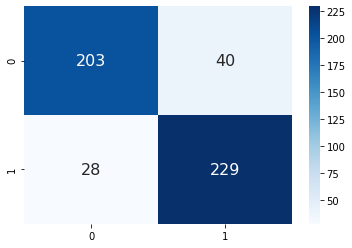

In [21]:
sns.heatmap(cm, annot=True, annot_kws={"size": 16}, cmap='Blues', fmt='g')